This notebook demonstrates how simple formation energy models can be trained on OQMD data using magpie descriptors (based on https://journals.aps.org/prb/abstract/10.1103/PhysRevB.96.024104) The 271 descriptors for each entry in OQMD  were precomputed using MatMiner, and provided as a pickle file.

In [1]:
import pandas as pd
import numpy as np
import time
import boto3
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from tqdm import tqdm

Download dataframe containing precomputed magpie descriptors, and formation energies: `s3://hackathon2020-prod/data/oqmd_1.2_voronoi_magpie_fingerprints.pickle`.

In [2]:
oqmd_pickle = 'oqmd_1.2_voronoi_magpie_fingerprints.pickle'

In [3]:
def hook(t):
  def inner(bytes_amount):
    t.update(bytes_amount)
  return inner

#session = boto3.session.Session(profile_name='hack2020')
#s3 = session.client('s3')
s3 = boto3.client('s3')
file_object = session.resource('s3').Object('hackathon2020-prod', 'data/' + oqmd_pickle)
filesize = file_object.content_length
with tqdm(total=filesize, unit='B', unit_scale=True, desc=oqmd_pickle) as t:
#path = "/tmp/{}".format(FILE_NAME)
    s3.download_file('hackathon2020-prod', 'data/' + oqmd_pickle, oqmd_pickle, Callback=hook(t))

oqmd_1.2_voronoi_magpie_fingerprints.pickle: 100%|██████████| 1.34G/1.34G [02:07<00:00, 10.5MB/s]


Load into dataframe.

In [5]:
df = pd.read_pickle(oqmd_pickle)

Since the data is in a pandas dataframe, we can conveniently inspect it. `delta_e` is the target column we would like to predict. We also will not need `oqmd_id` and `Composition` columns in training the model. The rest of the columns pertain to magpie descriptors computed for each OQMD entry.

In [6]:
df.columns

Index(['0-norm', '10-norm', '2-norm', '3-norm', '5-norm', '7-norm',
       'Composition', 'MagpieData avg_dev AtomicWeight',
       'MagpieData avg_dev Column', 'MagpieData avg_dev CovalentRadius',
       ...
       'range local difference in NfUnfilled',
       'range local difference in NfValence',
       'range local difference in NpUnfilled',
       'range local difference in NpValence',
       'range local difference in NsUnfilled',
       'range local difference in NsValence',
       'range local difference in Number', 'range local difference in Row',
       'range local difference in SpaceGroupNumber',
       'range neighbor distance variation'],
      dtype='object', length=276)

In [7]:
df.shape

(606121, 276)

Let's now drop the rows that have missing data, and identify any columns that are not np.float64. Straightforward with pandas:

In [8]:
df = df.dropna(axis=0, how='any')

In [9]:
not_float_cols = []
for col in df.columns:
    if df[col].dtype != np.float64:
        print(col, df[col].dtype)
        not_float_cols.append(col)

0-norm int64
Composition object
N_species int64
compound possible bool


Let's subsample the OQMD entries to be able to train models in a reasonable time frame (only for the purposes of this example, you can switch to the full dataset later)

In [10]:
df = df.sample(n=50000)

Prepare our target (y) and feature vectors (X) for training. We'll get rid of some columns without float values:

In [11]:
y = df['delta_e']
X = df.drop(not_float_cols+['delta_e'], axis=1)

We want to do k-fold cross-validation (CV) to test the performance of our models. Let's do a 3-fold split in this example.

In [12]:
kf = KFold(n_splits=3, shuffle=True, random_state=42)

We will collect the predicted and actual formation energies in each fold, to later use in model evaluation. Let's start the CV loop for a linear regression, which will serve as our baseline:

In [13]:
predictions_LR, truth_LR = [], []

for train_index, test_index in kf.split(X, y):
    
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Note we are reinitializing the scaler in each fold.
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    
    # This is where we train set of the current fold.
    regressor = LinearRegression()
    regressor.fit(X_train, y_train)
    
    # We should properly standardize our test X with the scaler fitted in this fold.
    X_test = scaler.transform(X_test)
    
    # This is where we make prediction on test set of the current fold.
    predictions_LR += regressor.predict(X_test).tolist()
    truth_LR += y_test.tolist()

Here is the mean absolute error (in eV/atom) for the linear regresson model:

In [14]:
print(mean_absolute_error(truth_LR, predictions_LR))

0.25718265105749766


Now let's do a similar evaluation for a more complex, non-linear model, such as Random Forest. We will also time this, as it takes significant amount of time.

In [15]:
predictions_RF, truth_RF = [], []

for train_index, test_index in kf.split(X, y):
    
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Note we are reinitializing the scaler in each fold.
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    
    # This is where we train set of the current fold.
    t0 = time.time()
    regressor = RandomForestRegressor(n_estimators=20, n_jobs=-1)
    regressor.fit(X_train, y_train)
    print(time.time()-t0, ' seconds for present fold.')
    
    # We should properly standardize our test X with the scaler fitted in this fold.
    X_test = scaler.transform(X_test)
    
    # This is where we make prediction on test set of the current fold.
    predictions_RF += regressor.predict(X_test).tolist()
    truth_RF += y_test.tolist()

30.34608793258667  seconds for present fold.
30.64005970954895  seconds for present fold.
37.89325499534607  seconds for present fold.


In the present problem, random forest can clearly deliver a much better CV score (in terms of mean absolute error), compared to a linear model (this may not always be the case in other ML tasks, so always check your baseline!):

In [16]:
print(mean_absolute_error(truth_RF, predictions_RF))

0.1506082398321542


Let's visualize the model predictions

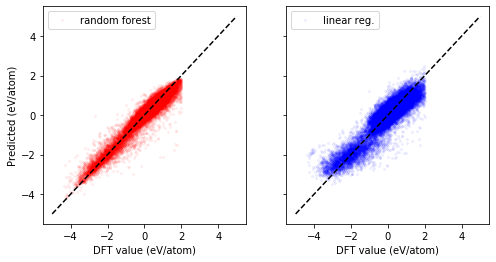

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, axes = plt.subplots(ncols=2, sharey=True, sharex=True, figsize=(8,4))
axes[0].plot(truth_RF, predictions_RF, 'ro', alpha=0.05, markersize=2, label='random forest')
axes[1].plot(truth_LR, predictions_LR, 'bo', alpha=0.05, markersize=2, label='linear reg.')
axes[0].set_ylabel('Predicted (eV/atom)')
for i in range(2):
    axes[i].set_xlabel('DFT value (eV/atom)')
    axes[i].plot([-5,5], [-5,5], 'k--')
    axes[i].legend()
plt.show()